##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [25]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [26]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#
# Load the csv data.
#
def load_data_arrays():
    data_path = "datasets/1_preprocessed.csv"
    df = pd.read_csv(data_path)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

train_df, test_df = load_data_arrays()

In [58]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df['text'].values, tf.string),
            tf.cast(train_df['is_hatespeech'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df['text'].values, tf.string),
            tf.cast(test_df['is_hatespeech'].values, tf.int32)
        )
    )
)

In [43]:
# dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

Initially this returns a dataset of (text, label pairs):

In [42]:
#for example, label in train_dataset.take(1):
#  print('text: ', example.numpy())
#  print('label: ', label.numpy())

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [59]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [60]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [62]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'the whole afternoon has been about the deep voiced bitch'
 b'megamindnick whitethunduh nah fam i gotta cheat with the hoes depends on the female i feel'
 b'because of the message that sends to lgbtq residents in the state not as if west virginia is a paradise for queer people today is major']

labels:  [1 1 1]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [63]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [64]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'a', 'bitch', 'rt', 'i', 'the', 'you', 'to', 'and',
       'my', 'that', 'in', 'bitches', 'is', 'like', 'me', 'of', 'on',
       'be'], dtype='<U27')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [65]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  6, 396,   1, 154, 132,  59,   6, 762,   1,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  1,   1, 289, 976,   5, 140, 656,  27,   6,  20,   1,  18,   6,
        493,   5, 206,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [134,  17,   6,   1,  11,   1,   8,   1,   1,  12,   6, 705,  47,
         77,  33,   1,   1,  14,   2,   1,  22, 427, 109, 196,  14,   1,
          0,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [66]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'the whole afternoon has been about the deep voiced bitch'
Round-trip:  the whole [UNK] has been about the deep [UNK] bitch                    

Original:  b'megamindnick whitethunduh nah fam i gotta cheat with the hoes depends on the female i feel'
Round-trip:  [UNK] [UNK] nah fam i gotta cheat with the hoes [UNK] on the female i feel              

Original:  b'because of the message that sends to lgbtq residents in the state not as if west virginia is a paradise for queer people today is major'
Round-trip:  because of the [UNK] that [UNK] to [UNK] [UNK] in the state not as if [UNK] [UNK] is a [UNK] for queer people today is [UNK]    



## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [67]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [68]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [69]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01583405]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [70]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01583405]


Compile the Keras model to configure the training process:

In [71]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [72]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
310/310 [==============================] - 8s 15ms/step - loss: 0.5008 - accuracy: 0.6553 - val_loss: 0.3450 - val_accuracy: 0.8609
Epoch 2/5
310/310 [==============================] - 4s 13ms/step - loss: 0.2343 - accuracy: 0.9081 - val_loss: 0.1603 - val_accuracy: 0.9391
Epoch 3/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1469 - accuracy: 0.9398 - val_loss: 0.1400 - val_accuracy: 0.9469
Epoch 4/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1279 - accuracy: 0.9490 - val_loss: 0.1401 - val_accuracy: 0.9469
Epoch 5/5
310/310 [==============================] - 4s 13ms/step - loss: 0.1197 - accuracy: 0.9523 - val_loss: 0.1434 - val_accuracy: 0.9500


In [73]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

78/78 [==============================] - 0s 6ms/step - loss: 0.1367 - accuracy: 0.9389
Test Loss: 0.13671953976154327
Test Accuracy: 0.9388743042945862


(0.0, 0.519855285808444)

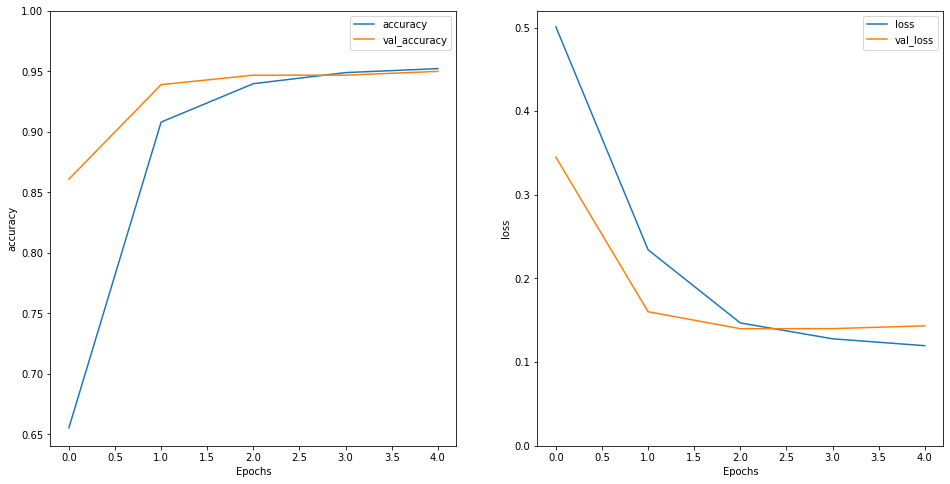

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [75]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [76]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [77]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [78]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
310/310 [==============================] - 17s 35ms/step - loss: 0.5155 - accuracy: 0.6236 - val_loss: 0.3514 - val_accuracy: 0.8599
Epoch 2/10
310/310 [==============================] - 8s 24ms/step - loss: 0.2237 - accuracy: 0.9150 - val_loss: 0.1642 - val_accuracy: 0.9354
Epoch 3/10
310/310 [==============================] - 8s 24ms/step - loss: 0.1432 - accuracy: 0.9445 - val_loss: 0.1494 - val_accuracy: 0.9474
Epoch 4/10
310/310 [==============================] - 8s 24ms/step - loss: 0.1278 - accuracy: 0.9488 - val_loss: 0.1482 - val_accuracy: 0.9469
Epoch 5/10
310/310 [==============================] - 8s 24ms/step - loss: 0.1208 - accuracy: 0.9525 - val_loss: 0.1449 - val_accuracy: 0.9464
Epoch 6/10
310/310 [==============================] - 8s 24ms/step - loss: 0.1156 - accuracy: 0.9546 - val_loss: 0.1472 - val_accuracy: 0.9391
Epoch 7/10
310/310 [==============================] - 7s 24ms/step - loss: 0.1125 - accuracy: 0.9561 - val_loss: 0.1507 - val_accuracy: 0.942

In [79]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

78/78 [==============================] - 1s 13ms/step - loss: 0.1450 - accuracy: 0.9419
Test Loss: 0.1449931561946869
Test Accuracy: 0.941900372505188


In [80]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-3.5773888]]


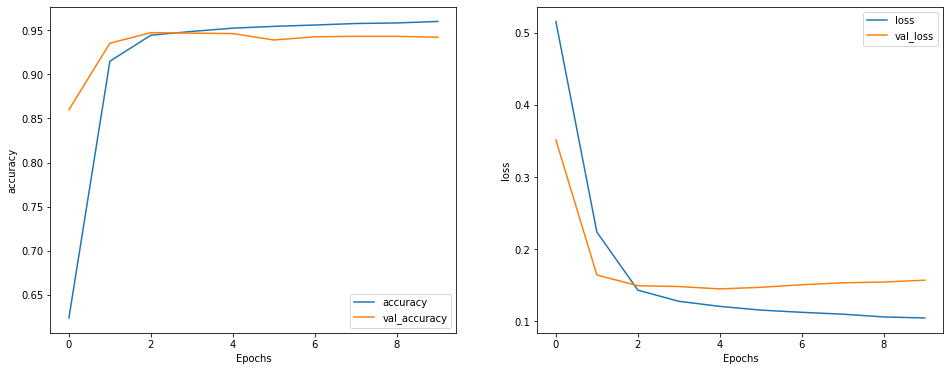

In [81]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
